# Getting Started
Let's begin by getting familiar with some of the relevant algorithms and datasets that we could use in the paper.
- [ ] Find several classic timeseries datasets: sunspots, stock prices, streamflow from the Mississippi River would all be fine, but bonus points if you find (or simulate) something more humerous.
- [ ] Try out several seasonal trend decompositions: STL, STR as example
- [ ] Try out fft and clipping out different `bands` from the frequency domain
- [ ] Put those pieces together to define a function for STF: seasonal-trend decomposition using the Fast-Fourier transform.

Good luck!

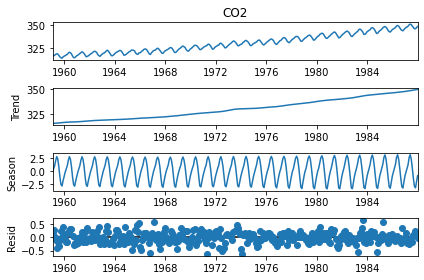

In [40]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt

co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()

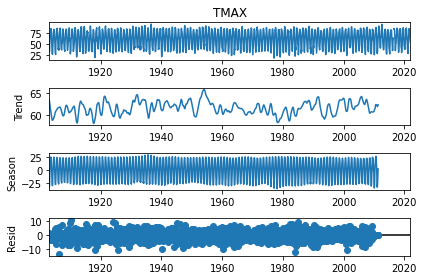

In [2]:
# Load in daily temperature data from station USC00118740
champaignTemp = pd.read_csv('../data/champaign_temps.csv', index_col='date', parse_dates=True, squeeze=True)

# Aggregate to find average max and min temperatures by month
champaignTemp = champaignTemp.resample('M').mean()

# STL on TMAX
stl = STL(champaignTemp["TMAX"])
res = stl.fit()
fig = res.plot()

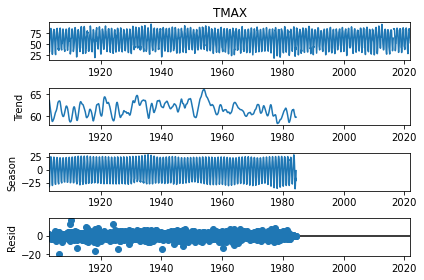

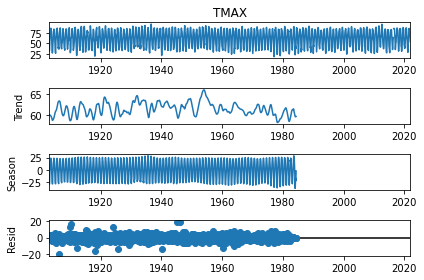

In [7]:
# STL on TMAX with robust = True
stl = STL(champaignTemp["TMAX"], robust = True)
res = stl.fit()
fig = res.plot()

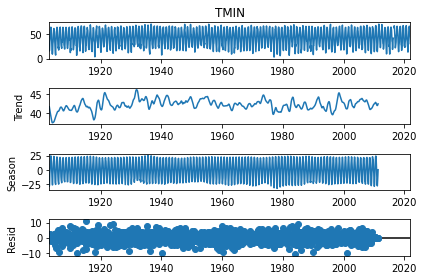

In [73]:
# STL on TMIN
stl = STL(champaignTemp["TMIN"])
res = stl.fit()
fig = res.plot()

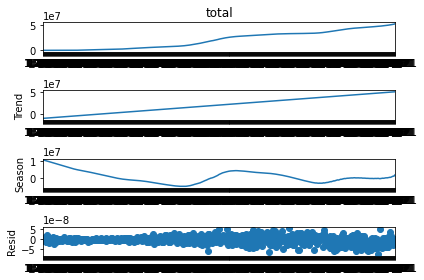

In [32]:
# STL on covid dataset

# Data cleaning
covid = pd.read_csv('../data/time_series_covid19_confirmed_US.csv', parse_dates=True, squeeze=True)
covid_dates = covid.iloc[:, 11:]
covid_dates = covid_dates.T
covid_dates["total"] = covid_dates.sum(axis=1)

stl = STL(covid_dates["total"], period = 365)
res = stl.fit()
fig = res.plot()



[0.00000000e+00 7.98212005e-07 1.59642401e-06 2.39463602e-06
 3.19284802e-06 3.99106003e-06 4.78927203e-06 5.58748404e-06
 6.38569604e-06 7.18390805e-06 7.98212005e-06 8.78033206e-06
 9.57854406e-06 1.03767561e-05 1.11749681e-05 1.19731801e-05
 1.27713921e-05 1.35696041e-05 1.43678161e-05 1.51660281e-05
 1.59642401e-05 1.67624521e-05 1.75606641e-05 1.83588761e-05
 1.91570881e-05 1.99553001e-05 2.07535121e-05 2.15517241e-05
 2.23499361e-05 2.31481481e-05 2.39463602e-05 2.47445722e-05
 2.55427842e-05 2.63409962e-05 2.71392082e-05 2.79374202e-05
 2.87356322e-05 2.95338442e-05 3.03320562e-05 3.11302682e-05
 3.19284802e-05 3.27266922e-05 3.35249042e-05 3.43231162e-05
 3.51213282e-05 3.59195402e-05 3.67177522e-05 3.75159642e-05
 3.83141762e-05 3.91123883e-05 3.99106003e-05 4.07088123e-05
 4.15070243e-05 4.23052363e-05 4.31034483e-05 4.39016603e-05
 4.46998723e-05 4.54980843e-05 4.62962963e-05 4.70945083e-05
 4.78927203e-05 4.86909323e-05 4.94891443e-05 5.02873563e-05
 5.10855683e-05 5.188378

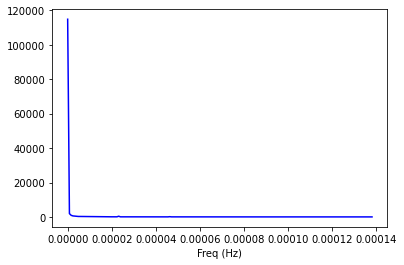

<ipython-input-94-c916072b9dc6>:20: RuntimeWarning: divide by zero encountered in true_divide
  t_h = 1 / f_oneside


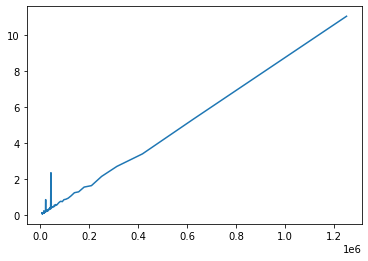

In [94]:
# Trying out fft on co2 data
from numpy.fft import fft, ifft
X = fft(co2)
N = len(X)
n = np.arange(N)

sr = 1 / (60*60)
T = N / sr
freq = n/T
print(freq)
n_oneside = int(N/2)

f_oneside = freq[:n_oneside]

plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
plt.xlabel('Freq (Hz)')
plt.show()


t_h = 1 / f_oneside 

plt.plot(t_h, np.abs(X[:n_oneside] / n_oneside))
plt.show()

